In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import PIL
import json
import logging
import re  
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
configuration = Config()
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

In [4]:
from dataset import overall_joints_dataset
from prediction import joint_damage
from dataset.joints.joint_extractor_factory import get_joint_extractor

In [5]:
def robust_mean(scores):
    scores = np.sort(scores)
    size_p = len(scores)//10
    mean_score = np.mean(scores[size_p:len(scores)-size_p])
    return mean_score
    
def _prepare_image(img_arr):
    imgs = [np.expand_dims(x.numpy(),0) for x in img_arr]
    return imgs

In [6]:
def hands_metric(model,erosion = False, repeated = False):
    hands_model = keras.models.load_model(model, compile = False)
    hand_extractor = get_joint_extractor("H", erosion) 
    ds = overall_joints_dataset.hands_overall_joints_dataset(configuration, 'test', joint_extractor = hand_extractor, force_augment = repeated, erosion_flag = erosion).create_hands_overall_joints_dataset("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv",joints_source = './data/predictions/hand_joint_data_test_v2.csv')
    results = {}
    n = 1
    if repeated:
        n = 20
    for iteration in range(n):
        for x in ds:
            imgs, img_id = _prepare_image(x[1]), x[0].numpy()[0].decode("utf-8")
            res = hands_model.predict(imgs)
            try:
                results[img_id].append(res[0][0])
            except:
                results[img_id] = [res[0][0]]
    for item in results:
        results[item] = robust_mean(results[item])
        
    result = pd.DataFrame.from_dict(results,orient='index')
    result.columns = ["Prediction"]
    result["patient"] = result.index.str.split("-").str[0]
    result["side"] = result.index.str.split("-").str[1]
    result = result.pivot(index = "patient", values="Prediction", columns="side")

    ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
    ground_truth_df = ground_truth_df.set_index("Patient_ID")
    what = ".*H.*J.*"
    if erosion:
        what = ".*H.*E.*"
    what = re.compile(what)
    wanted_cols = list(filter(what.match, ground_truth_df.columns))
    merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
    truth_idx = ["LH_" in x for x in merged_df.columns]
    merged_df["Overall_truth LH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
    truth_idx = ["RH_" in x for x in merged_df.columns]
    merged_df["Overall_truth RH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
    
    sns.scatterplot(data = merged_df, x="Overall_truth RH",y="RH")
    
    print(mean_absolute_error(merged_df["Overall_truth LH"],merged_df["LH"]))
    print(mean_absolute_error(merged_df["Overall_truth RH"],merged_df["RH"]))
    print(mean_absolute_error(merged_df.loc[merged_df["Overall_truth RH"] > 5,"Overall_truth RH"],merged_df.loc[merged_df["Overall_truth RH"] > 5,"RH"]))

2.7175841003983887
2.260825839998958
5.11177476814815


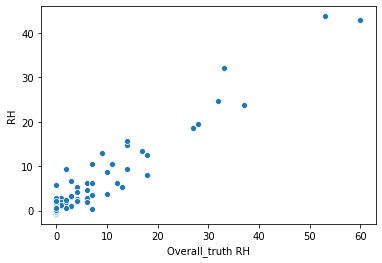

In [7]:
hands_metric("weights/SC1_v6_hand_narrowing_mae_adamw3after_model_100.h5", False)

2.5418368669656606
2.1685225934117707
5.132815690977233


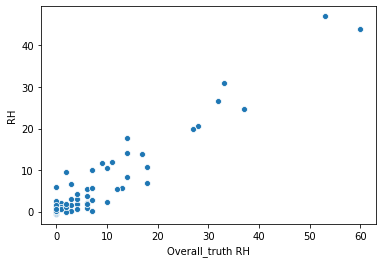

In [131]:
hands_metric("weights/SC1_v6_hand_narrowing_mae_adamw3_0.75after_model_100.h5", False)

2.6067184686333267
2.336974870700103
5.4282548278570175


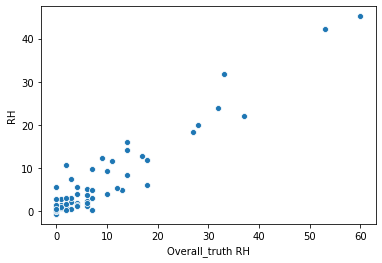

In [8]:
hands_metric("weights/SC1_v6_hand_narrowing_mae_adamw3_0.60after_model_100.h5", False)

3.408158549240657
3.8749613973138097
18.41202529668808


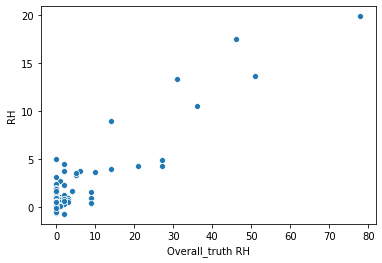

In [136]:
hands_metric("weights/SC1_v6_hand_erosion_mae_adamw3_0.75after_model_100.h5", True)

3.382113923410793
3.8777442415664485
18.240513706207274


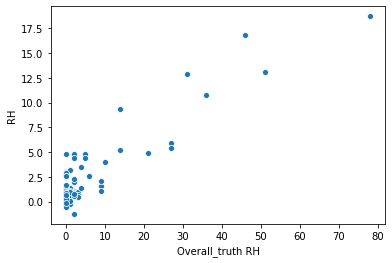

In [7]:
hands_metric("weights/SC1_v6_hand_erosion_mae_adamw3_0.60after_model_100.h5", True)

# feet

In [9]:
def feet_metric(model,erosion = False, repeated = False):
    feet_model = keras.models.load_model(model, compile = False)
    foot_extractor = get_joint_extractor("F", erosion)
    ds = overall_joints_dataset.feet_overall_joints_dataset(configuration, 'test', joint_extractor = foot_extractor, force_augment = repeated, erosion_flag = erosion).create_feet_overall_joints_dataset("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv",joints_source = './data/predictions/feet_joint_data_test_v2.csv')
    results = {}
    n = 1
    if repeated:
        n = 20
    for iteration in range(n):
        for x in ds:
            imgs, img_id = _prepare_image(x[1]), x[0].numpy()[0].decode("utf-8")
            res = feet_model.predict(imgs)
            try:
                results[img_id].append(res[0][0])
            except:
                results[img_id] = [res[0][0]]

    for item in results:
        results[item] = sum(results[item])/len(results[item])

    result = pd.DataFrame.from_dict(results,orient='index')
    result.columns = ["Prediction"]
    result["patient"] = result.index.str.split("-").str[0]
    result["side"] = result.index.str.split("-").str[1]
    result = result.pivot(index = "patient", values="Prediction", columns="side")

    ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
    ground_truth_df = ground_truth_df.set_index("Patient_ID")
    what = ".*F.*J.*"
    if erosion:
        what = ".*F.*E.*"
    what = re.compile(what)
    wanted_cols = list(filter(what.match, ground_truth_df.columns))
    merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
    truth_idx = ["LF_" in x for x in merged_df.columns]
    merged_df["Overall_truth LF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
    truth_idx = ["RF_" in x for x in merged_df.columns]
    merged_df["Overall_truth RF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
    
    sns.scatterplot(data = merged_df, x="Overall_truth RF",y="RF")
    
    print(mean_absolute_error(merged_df["Overall_truth LF"],merged_df["LF"]))
    print(mean_absolute_error(merged_df["Overall_truth RF"],merged_df["RF"]))
    print(mean_absolute_error(merged_df.loc[merged_df["Overall_truth RF"] > 5,"Overall_truth RF"],merged_df.loc[merged_df["Overall_truth RF"] > 5,"RF"]))

1.0507967924023722
1.3131133274553897
3.048786291709313


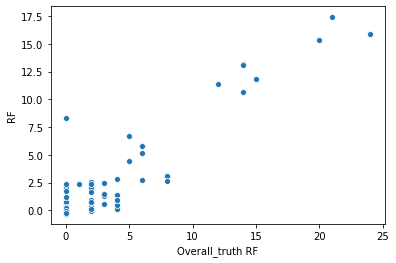

In [11]:
feet_metric("weights/SC1_v6_feet_narrowing_mae_adamw3_0.60after_model_100.h5", False)

1.0506242974036997
1.3090705131477378
2.9941355384313146


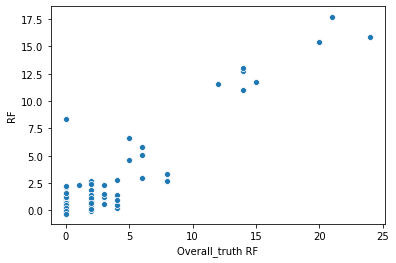

In [10]:
feet_metric("weights/SC1_v6_feet_narrowing_mae_adamw3_0.60after_model_100.h5", False, True)

1.9780142395705966
2.083208148296063
9.268667716246386


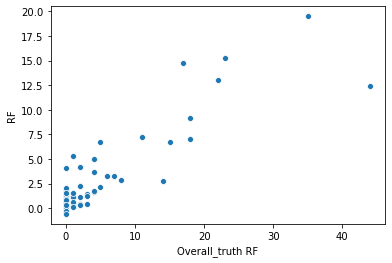

In [12]:
feet_metric("weights/SC1_v6_feet_erosion_mae_adamw3_0.60after_model_100.h5", True)

1.9653595331114724
2.0996590923558878
9.274587202989137


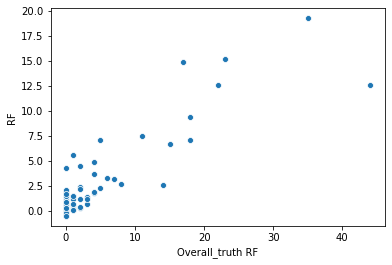

In [11]:
feet_metric("weights/SC1_v6_feet_erosion_mae_adamw3_0.60after_model_100.h5", True, True)